In [1]:
print("hello world")

hello world


In [2]:
from dotenv import load_dotenv
import os
load_dotenv()



True

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [4]:
gemini_api_key = os.getenv("gemini_api_key")

In [5]:
if not gemini_api_key:
    raise ValueError("No Gemini API key found. Please set the GEMINI_API_KEY environment variable.")

chat_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", google_api_key=gemini_api_key)




In [6]:
chat_llm.invoke("hi")

AIMessage(content=[{'type': 'text', 'text': 'Hello! How can I help you today?', 'extras': {'signature': 'EqsCCqgCAb4+9vspiajsERQgmunk9HiJ7lr7pH56vLrIPf+4kKtF7kqDd35dvMFbxkYb02i8HzreXvK56GgkWFzljkYn3JUPhwRZhpcvt+g7yGbFA3tmRScUjpGDlrcvs7qM+SHRFgebobzIb02kStHX/vP8HqMfDZfL9knsJbUdKlFyzAusydPxg1CB7g6K1B8CkqlzQr2ket2vKNYZMOM431MzcJcgk95d6qKjvXjmXepwjprxb5L+jKbghahAddrud8AyM9L+XgqATW8NZUkw+z4Kf8Zi+xvaExVPtFVH0O8Wyf7UMroHdqxuqOTzVt27l2G5+8cptGrNd+aQuRRVkz0fBu3DmFapOMMe7z3ZN4g3OiaTT0SgyNos3TF/iZEhDpLARqtKBEadckI='}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c76dc-1f67-7b72-94d6-183ed9695e4e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2, 'output_tokens': 77, 'total_tokens': 79, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 68}})

In [7]:
from typing_extensions import TypedDict, Annotated
import operator

In [8]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [9]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [10]:
["hi"]

['hi']

In [11]:
["hi", "how are you"]

['hi', 'how are you']

In [12]:
def llm_call(state: GraphState) -> dict:
    """Call the LLM using conversation messages and append AI response."""
    response = chat_llm.invoke(state["messages"])  # AIMessage
    return {
        "messages": [response]
    }

In [13]:
def token_counter(state: GraphState) -> dict:
    """Count tokens (simple word count) in the last AI message."""
    last_msg = state["messages"][-1]
    content = last_msg.content
    # AIMessage.content can be str or list of blocks (e.g. multimodal/tool calls)
    if isinstance(content, list):
        text = " ".join(
            (c.get("text", c) if isinstance(c, dict) else str(c)) for c in content
        )
    else:
        text = content or ""
    token_number = len(text.split())
    summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {
        "messages": [AIMessage(content=summary)]
    }


In [14]:
from langgraph.graph import StateGraph

In [15]:
builder = StateGraph(GraphState)

In [16]:

builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [17]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [18]:
app = builder.compile()

In [19]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

In [20]:
from IPython.display import Image, display

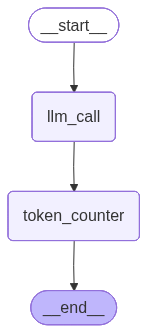

In [21]:

display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
result = app.invoke({
    "messages": [HumanMessage(content="Hi, this is Prince. Say hello in detail.")]
})

In [23]:
result

{'messages': [HumanMessage(content='Hi, this is Prince. Say hello in detail.', additional_kwargs={}, response_metadata={}),
  AIMessage(content=[{'type': 'text', 'text': "Hello there, Prince! It is an absolute pleasure to meet you.\n\nI hope you are having a wonderful day so far. It’s a privilege to welcome you into this conversation. Whether you’re here to brainstorm some brilliant ideas, solve a complex problem, dive into a deep discussion, or just have an engaging chat, I am ready and eager to assist you.\n\nSince you asked for a detailed greeting: consider this a warm, formal digital handshake and an open invitation to explore whatever is on your mind. I'm here to provide information, creativity, or just a friendly ear whenever you need it.\n\nHow are you doing today, Prince? Is there anything specific I can help you with?", 'extras': {'signature': 'Et0PCtoPAb4+9vsslHwOJBUFdqFeSyVbjSzQn189KGIvwTeq1j1lcBkqaUbjLbnt6lQdN8LvVZwqlaEB37xfeLqicPO45488UnlOsLf/Bq8qp1QjnKEqPGdfqEqseQzJsZCR/a

In [24]:
for m in result["messages"]:
    print(type(m).__name__, ":", m.content)

HumanMessage : Hi, this is Prince. Say hello in detail.
AIMessage : [{'type': 'text', 'text': "Hello there, Prince! It is an absolute pleasure to meet you.\n\nI hope you are having a wonderful day so far. It’s a privilege to welcome you into this conversation. Whether you’re here to brainstorm some brilliant ideas, solve a complex problem, dive into a deep discussion, or just have an engaging chat, I am ready and eager to assist you.\n\nSince you asked for a detailed greeting: consider this a warm, formal digital handshake and an open invitation to explore whatever is on your mind. I'm here to provide information, creativity, or just a friendly ear whenever you need it.\n\nHow are you doing today, Prince? Is there anything specific I can help you with?", 'extras': {'signature': 'Et0PCtoPAb4+9vsslHwOJBUFdqFeSyVbjSzQn189KGIvwTeq1j1lcBkqaUbjLbnt6lQdN8LvVZwqlaEB37xfeLqicPO45488UnlOsLf/Bq8qp1QjnKEqPGdfqEqseQzJsZCR/aHfNn9+6U9wheuI84xACFXaqVTXeBObsHGYl7lxMqj4kwMSGy5Hzyf+Of4SXlA30vffj6Q6oBDdbZ

In [25]:
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-3-flash-preview', temperature=1.0, client=<google.genai.client.Client object at 0x11e10a900>, default_metadata=(), model_kwargs={})

In [26]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [27]:
api_wrapper=WikipediaAPIWrapper(top_k_results=5,doc_content_chars_max= 500)

In [28]:
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [29]:
wiki_tool.run({"query":"Generative AI"})

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

In [31]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("tavily_api_key")

In [32]:
tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

/var/folders/xy/n5k80q155_jd3hsy_lgl8nch0000gn/T/ipykernel_47029/1068719361.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [37]:
tool.invoke({"query":"how is the job market for fresh graduates in 2026?"})

[{'title': 'The 2026 Job Market: Supporting Students and Closing the Skills Gap',
  'url': 'https://findingequilibriumfuturehighered.substack.com/p/the-2026-job-market-supporting-students',
  'content': "# Finding Equilibrium: Two Economists on Higher Ed's Future\n\n# The 2026 Job Market: Supporting Students and Closing the Skills Gap\n\n### Ideas for Preparing More Career-Ready Graduates\n\nJay Akridge and David Hummels\n\nDec 19, 2025\n\nWe’ve written a couple of times this fall on the current job market for new college graduates. The bottom-line: the Class of 2026 is likely to have more trouble finding a job.\n\nStudents are concerned: about 61% of the Class of 2026 students find current news about the job market somewhat or very pessimistic – up from 50% for the Class of 2024. High competition for jobs and lack of available jobs top the list of reasons for that pessimism, with the political climate and AI much more important factors this year relative to last.\n\nSource: Handshake.

In [39]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [40]:
search.invoke("what is the latest update on iphone17 release?")

Impersonate 'safari_15.3' does not exist, using 'random'


"4 days ago - It was announced on June 5, 2023, at Apple's annual Worldwide Developers Conference alongside watchOS 10, iPadOS 17, tvOS 17 and macOS Sonoma. It was made publicly available on September 18, 2023 , as a free software update for supported iOS devices (see the supported devices section). 1 week ago - T-Mobile’s brief corroborates this: every variant of the iPhone 17—Standard, Air, Pro, and Pro Max—was set to launch on September 19, 2025 . The 2025 iPhone 17 lineup comprises several models: iPhone 17, iPhone 17 Air, iPhone 17 Pro, and ... October 9, 2025 - The iPhone 17e is rumoured to launch in the spring of 2026 . Read on for more detailed analysis of the new iPhone 17 colors, cameras, battery life, specs, and features, plus the iPhone 17 release date and pricing. 2 days ago - Apple has sent out invites for a global 'experience' event for early next month. We're betting the new iPhone 17e will be unveiled then, along with a new iPad and a low-cost MacBook. But for the most

In [41]:
from langchain_community.tools import YouTubeSearchTool

In [42]:
tool=YouTubeSearchTool()

In [43]:
tool.name

'youtube_search'

In [44]:
tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [45]:
tool.run("free code camp")

"['https://www.youtube.com/watch?v=rfscVS0vtbw&pp=ygUOZnJlZSBjb2RlIGNhbXA%3D', 'https://www.youtube.com/watch?v=NhDYbskXRgc&pp=ygUOZnJlZSBjb2RlIGNhbXDSBwkJhwoBhyohjO8%3D']"

In [ ]:
''' we created a custom function'''
def multiply(a:int,b:int) -> int:
    return a*b

In [47]:
multiply(10,20)

200

In [ ]:
''' this does not work because it is not a tool '''
multiply.invoke(10,20)

AttributeError: 'function' object has no attribute 'invoke'

In [49]:
from langchain.tools import tool

In [55]:
''' we created a custom tool by using the tool decorator '''
@tool 
def multiply(a:int,b:int) -> int:
    '''this tool is for the multiplication'''
    return a*b

In [53]:
multiply.invoke({"a":10,"b":20})

200

In [ ]:
''' accessing the tool properties '''
multiply.name

'multiply'

In [57]:
multiply.description

'this tool is for the multiplication'

In [58]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [59]:
@tool
def get_word_length(word:str) -> int:
    """it is a tool to count the length of the word"""
    return len(word)

In [60]:
get_word_length.invoke("hello world")

11

In [61]:
get_word_length.invoke({"word": "hello world"})

11